# Predicting NHL Game Outcomes

## Sandbox Notebook

Working notebook 
When components (e.g. scraping functions) are working, move them to eventual production home

In [10]:
# Standard Packages
import pandas as pd
from pandas.testing import assert_frame_equal
import numpy as np
import requests
import re
import time
import os
import warnings

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, \
GridSearchCV, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
PolynomialFeatures, PowerTransformer, Normalizer, MaxAbsScaler

from sklearn.impute import SimpleImputer

## SKLearn Classification Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor

## SKLearn Pipeline Setup
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression

# ## Boosting
# from xgboost import XGBRegressor
from xgboost import XGBClassifier

## SKLearn Metrics
### Classification Scoring/Evaluation
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, \
ConfusionMatrixDisplay, log_loss, confusion_matrix, RocCurveDisplay, make_scorer, roc_auc_score

In [11]:
# Notebook Config
from pprintpp import pprint as pp
%reload_ext pprintpp
from tqdm import tqdm
from io import StringIO

## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = 20
# pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

In [12]:
# Scraping Requirents
from bs4 import BeautifulSoup


## EDA

In [13]:
# home_game_log_2021 = pd.read_csv('data/21_22-home-game-log.csv')
# home_game_log_2021

In [14]:
# home_game_log_2021.info()

### Top line feature (column) deletion and addition

Deleting:
- 'Unnamed: 2' held hyperlinks to related pages
- 'C' type (Corsi) shot stats 
  - we will be using 'F' type (Fenwick) shots (goals, on net and misses, but excludes blocks)
- 'SC' type (Scoring Chance) vars
    - we will be focusing on HD type

In [15]:
print(home_df.columns)

Index(['Game', 'Team', 'Unnamed: 2', 'TOI', 'CF/60', 'CA/60', 'CF%', 'FF/60',
       'FA/60', 'FF%', 'SF/60', 'SA/60', 'SF%', 'GF/60', 'GA/60', 'GF%',
       'xGF/60', 'xGA/60', 'xGF%', 'SCF/60', 'SCA/60', 'SCF%', 'HDCF/60',
       'HDCA/60', 'HDCF%', 'HDGF/60', 'HDGA/60', 'HDGF%', 'HDSH%', 'HDSV%',
       'SH%', 'SV%', 'PDO'],
      dtype='object')


## EDA V2

In [16]:
home_df = pd.read_csv('data/home-19-22-5v5-adjusted.csv')
away_df = pd.read_csv('data/away-19-22-5v5-adjusted.csv')
print(home_df.shape, away_df.shape)

(3262, 33) (3262, 33)


In [17]:
# Store column names in list for easier manipulation
game_log_cols = home_df.columns.to_list()
print([col for col in home_df])

['Game', 'Team', 'Unnamed: 2', 'TOI', 'CF/60', 'CA/60', 'CF%', 'FF/60', 'FA/60', 'FF%', 'SF/60', 'SA/60', 'SF%', 'GF/60', 'GA/60', 'GF%', 'xGF/60', 'xGA/60', 'xGF%', 'SCF/60', 'SCA/60', 'SCF%', 'HDCF/60', 'HDCA/60', 'HDCF%', 'HDGF/60', 'HDGA/60', 'HDGF%', 'HDSH%', 'HDSV%', 'SH%', 'SV%', 'PDO']


In [18]:
# import data was filtered -  need to check validity of a few
# PDO - only reported for home team in this version of the data

In [19]:
# Columns to immediately drop
drop_on_load = ['Unnamed: 2']

In [20]:
# Cols I need to add back in
cols_to_add = ['is_home_team', 'home_team_goals', 'home_team_won']

In [21]:
# pd.testing.assert_frame_equal(home_df, away_df, check_dtype=False , check_index_type=False, 
#                               check_frame_type=False, check_names=False, 
#                               check_column_type=False, check_categorical=False)

# # 


In [22]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Game        3262 non-null   object 
 1   Team        3262 non-null   object 
 2   Unnamed: 2  3262 non-null   object 
 3   TOI         3262 non-null   float64
 4   CF/60       3262 non-null   float64
 5   CA/60       3262 non-null   float64
 6   CF%         3262 non-null   float64
 7   FF/60       3262 non-null   float64
 8   FA/60       3262 non-null   float64
 9   FF%         3262 non-null   float64
 10  SF/60       3262 non-null   float64
 11  SA/60       3262 non-null   float64
 12  SF%         3262 non-null   float64
 13  GF/60       3262 non-null   float64
 14  GA/60       3262 non-null   float64
 15  GF%         3262 non-null   object 
 16  xGF/60      3262 non-null   float64
 17  xGA/60      3262 non-null   float64
 18  xGF%        3262 non-null   float64
 19  SCF/60      3262 non-null  

In [23]:
away_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Game        3262 non-null   object 
 1   Team        3262 non-null   object 
 2   Unnamed: 2  3262 non-null   object 
 3   TOI         3262 non-null   float64
 4   CF/60       3262 non-null   float64
 5   CA/60       3262 non-null   float64
 6   CF%         3262 non-null   float64
 7   FF/60       3262 non-null   float64
 8   FA/60       3262 non-null   float64
 9   FF%         3262 non-null   float64
 10  SF/60       3262 non-null   float64
 11  SA/60       3262 non-null   float64
 12  SF%         3262 non-null   float64
 13  GF/60       3262 non-null   float64
 14  GA/60       3262 non-null   float64
 15  GF%         3262 non-null   object 
 16  xGF/60      3262 non-null   float64
 17  xGA/60      3262 non-null   float64
 18  xGF%        3262 non-null   float64
 19  SCF/60      3262 non-null  

In [24]:
home_df.index

RangeIndex(start=0, stop=3262, step=1)

In [25]:
# Store column names in list for easier manipulation
home_cols = home_df.columns.to_list()
print([col for col in home_cols])

['Game', 'Team', 'Unnamed: 2', 'TOI', 'CF/60', 'CA/60', 'CF%', 'FF/60', 'FA/60', 'FF%', 'SF/60', 'SA/60', 'SF%', 'GF/60', 'GA/60', 'GF%', 'xGF/60', 'xGA/60', 'xGF%', 'SCF/60', 'SCA/60', 'SCF%', 'HDCF/60', 'HDCA/60', 'HDCF%', 'HDGF/60', 'HDGA/60', 'HDGF%', 'HDSH%', 'HDSV%', 'SH%', 'SV%', 'PDO']


In [26]:
# check colums are equal now that names are issolated
away_cols = away_df.columns.to_list()
assert home_cols == away_cols

In [27]:
cols_to_drop = ['Unnamed: 2', 'CF/60', 'CA/60', 'CF%', 'SF/60', 'SA/60', 'SF%', 'GF%',
                'SCF/60', 'SCA/60', 'SCF%', 'HDGF/60', 'HDGA/60', 'HDGF%', 'HDSH%', 'HDSV%']

# cols to engineer in future
## standing points gained to date and for several moving averages (5 , 10, 20) - explain hot and cold streaks?

In [28]:
home_df = home_df.drop(columns= cols_to_drop, axis=1)
home_df

,Game,Team,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,xGF%,HDCF/60,HDCA/60,HDCF%,SH%,SV%,PDO
0,"2019-10-02 - Senators 3, Maple Leafs 5",Toronto Maple Leafs,44.133333,59.15,43.75,57.48,5.16,4.18,3.44,2.22,60.73,15.74,8.32,65.42,11.94,85.60,0.975
1,"2019-10-02 - Capitals 3, Blues 2",St Louis Blues,50.866667,27.17,39.14,40.97,1.11,1.20,1.35,2.26,37.48,5.59,6.14,47.66,5.56,95.79,1.014
2,"2019-10-02 - Canucks 2, Oilers 3",Edmonton Oilers,47.066667,30.38,48.03,38.75,3.58,2.64,1.71,1.99,46.24,6.04,9.11,39.87,14.87,91.33,1.062
3,"2019-10-02 - Sharks 1, Golden Knights 4",Vegas Golden Knights,45.666667,51.94,30.07,63.34,2.60,1.33,3.84,1.40,73.28,16.02,5.27,75.25,8.07,93.28,1.013
4,"2019-10-03 - Panthers 2, Lightning 5",Tampa Bay Lightning,45.500000,32.45,46.56,41.07,2.55,1.33,1.86,1.69,52.43,11.77,9.26,55.98,9.94,96.45,1.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,"2022-04-29 - Avalanche 1, Wild 4",Minnesota Wild,39.400000,30.65,46.61,39.67,4.44,1.53,1.95,1.95,50.05,7.71,5.99,56.30,19.79,95.50,1.153
3258,"2022-04-29 - Flames 1, Jets 3",Winnipeg Jets,47.916667,59.43,45.89,56.43,2.34,1.32,4.08,2.44,62.52,18.27,9.15,66.62,5.34,96.02,1.014
3259,"2022-04-29 - Predators 4, Coyotes 5",Arizona Coyotes,48.750000,31.75,58.08,35.34,5.73,5.25,1.60,3.01,34.78,4.30,13.88,23.67,25.11,83.60,1.087
3260,"2022-04-29 - Sharks 0, Kraken 3",Seattle Kraken,52.416667,48.21,26.93,64.16,2.21,0.00,2.42,1.42,62.98,11.58,4.54,71.82,6.82,100.00,1.068


In [29]:
home_df['TOI'].equals(away_df['TOI'])

True

In [30]:
# drop same cols from away_df
away_df = away_df.drop(columns= cols_to_drop, axis=1)
assert away_df.shape  == home_df.shape

In [31]:
# extract date from game field
home_df['date'] = home_df['Game'].str[:11]
away_df['date'] = away_df['Game'].str[:11]
# change 'Team' field to 'isHomeTeam'
home_df['isHomeTeam'] = home_df['Team']
away_df['isAwayTeam'] = away_df['Team']

In [32]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Game        3262 non-null   object 
 1   Team        3262 non-null   object 
 2   TOI         3262 non-null   float64
 3   FF/60       3262 non-null   float64
 4   FA/60       3262 non-null   float64
 5   FF%         3262 non-null   float64
 6   GF/60       3262 non-null   float64
 7   GA/60       3262 non-null   float64
 8   xGF/60      3262 non-null   float64
 9   xGA/60      3262 non-null   float64
 10  xGF%        3262 non-null   float64
 11  HDCF/60     3262 non-null   float64
 12  HDCA/60     3262 non-null   float64
 13  HDCF%       3262 non-null   float64
 14  SH%         3262 non-null   float64
 15  SV%         3262 non-null   float64
 16  PDO         3262 non-null   float64
 17  date        3262 non-null   object 
 18  isHomeTeam  3262 non-null   object 
dtypes: float64(15), object(4)
m

In [33]:
away_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Game        3262 non-null   object 
 1   Team        3262 non-null   object 
 2   TOI         3262 non-null   float64
 3   FF/60       3262 non-null   float64
 4   FA/60       3262 non-null   float64
 5   FF%         3262 non-null   float64
 6   GF/60       3262 non-null   float64
 7   GA/60       3262 non-null   float64
 8   xGF/60      3262 non-null   float64
 9   xGA/60      3262 non-null   float64
 10  xGF%        3262 non-null   float64
 11  HDCF/60     3262 non-null   float64
 12  HDCA/60     3262 non-null   float64
 13  HDCF%       3262 non-null   float64
 14  SH%         3262 non-null   float64
 15  SV%         3262 non-null   float64
 16  PDO         3262 non-null   float64
 17  date        3262 non-null   object 
 18  isAwayTeam  3262 non-null   object 
dtypes: float64(15), object(4)
m

In [34]:
# home_df['home_score'] = home_df['Game'][0][-1]
# home_df

In [53]:
all_sit_goals = pd.read_csv('data/all-sit-19-22-results.csv') # usecols=['GF', 'xGF', 'GA', 'xGA']
all_sit_goals

,Game,Team,Unnamed: 2,TOI,GF,GA,GF%,xGF,xGA,xGF%
0,"2019-10-02 - Senators 3, Maple Leafs 5",Toronto Maple Leafs,Limited ReportFull Report,60.00,5,3,62.50,4.43,2.21,66.75
1,"2019-10-02 - Capitals 3, Blues 2",St Louis Blues,Limited ReportFull Report,62.85,2,3,40.00,1.61,2.76,36.76
2,"2019-10-02 - Canucks 2, Oilers 3",Edmonton Oilers,Limited ReportFull Report,60.00,3,2,60.00,1.69,2.94,36.42
3,"2019-10-02 - Sharks 1, Golden Knights 4",Vegas Golden Knights,Limited ReportFull Report,60.00,4,1,80.00,3.79,1.70,69.10
4,"2019-10-03 - Panthers 2, Lightning 5",Tampa Bay Lightning,Limited ReportFull Report,60.00,5,2,71.43,2.55,1.83,58.18
...,...,...,...,...,...,...,...,...,...,...
3257,"2022-04-29 - Avalanche 1, Wild 4",Minnesota Wild,Limited ReportFull Report,60.00,4,1,80.00,2.76,1.83,60.11
3258,"2022-04-29 - Flames 1, Jets 3",Winnipeg Jets,Limited ReportFull Report,60.00,3,1,75.00,4.96,2.74,64.40
3259,"2022-04-29 - Predators 4, Coyotes 5",Arizona Coyotes,Limited ReportFull Report,60.00,5,4,55.56,3.35,3.35,49.95
3260,"2022-04-29 - Sharks 0, Kraken 3",Seattle Kraken,Limited ReportFull Report,60.00,3,0,100.00,2.92,1.71,63.12


In [54]:
all_sit_goals.drop(columns=['Unnamed: 2', 'Game', 'Team'], inplace=True)
all_sit_goals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TOI     3262 non-null   float64
 1   GF      3262 non-null   int64  
 2   GA      3262 non-null   int64  
 3   GF%     3262 non-null   object 
 4   xGF     3262 non-null   float64
 5   xGA     3262 non-null   float64
 6   xGF%    3262 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 178.5+ KB


In [55]:
away_df = pd.concat([away_df, all_sit_goals], axis=1)

In [56]:
home_df = pd.concat([home_df, all_sit_goals], axis=1)
home_df

,Game,Team,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,...,xGA,home_win,home_goal_dif,TOI,GF,GA,GF%,xGF,xGA,xGF%
0,"2019-10-02 - Senators 3, Maple Leafs 5",Toronto Maple Leafs,44.133333,59.15,43.75,57.48,5.16,4.18,3.44,2.22,...,2.21,1,2,60.00,5,3,62.50,4.43,2.21,66.75
1,"2019-10-02 - Capitals 3, Blues 2",St Louis Blues,50.866667,27.17,39.14,40.97,1.11,1.20,1.35,2.26,...,2.76,0,-1,62.85,2,3,40.00,1.61,2.76,36.76
2,"2019-10-02 - Canucks 2, Oilers 3",Edmonton Oilers,47.066667,30.38,48.03,38.75,3.58,2.64,1.71,1.99,...,2.94,1,1,60.00,3,2,60.00,1.69,2.94,36.42
3,"2019-10-02 - Sharks 1, Golden Knights 4",Vegas Golden Knights,45.666667,51.94,30.07,63.34,2.60,1.33,3.84,1.40,...,1.70,1,3,60.00,4,1,80.00,3.79,1.70,69.10
4,"2019-10-03 - Panthers 2, Lightning 5",Tampa Bay Lightning,45.500000,32.45,46.56,41.07,2.55,1.33,1.86,1.69,...,1.83,1,3,60.00,5,2,71.43,2.55,1.83,58.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,"2022-04-29 - Avalanche 1, Wild 4",Minnesota Wild,39.400000,30.65,46.61,39.67,4.44,1.53,1.95,1.95,...,1.83,1,3,60.00,4,1,80.00,2.76,1.83,60.11
3258,"2022-04-29 - Flames 1, Jets 3",Winnipeg Jets,47.916667,59.43,45.89,56.43,2.34,1.32,4.08,2.44,...,2.74,1,2,60.00,3,1,75.00,4.96,2.74,64.40
3259,"2022-04-29 - Predators 4, Coyotes 5",Arizona Coyotes,48.750000,31.75,58.08,35.34,5.73,5.25,1.60,3.01,...,3.35,1,1,60.00,5,4,55.56,3.35,3.35,49.95
3260,"2022-04-29 - Sharks 0, Kraken 3",Seattle Kraken,52.416667,48.21,26.93,64.16,2.21,0.00,2.42,1.42,...,1.71,1,3,60.00,3,0,100.00,2.92,1.71,63.12


In [57]:
home_df['date'] = pd.to_datetime(home_df['date'])
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Game           3262 non-null   object        
 1   Team           3262 non-null   object        
 2   TOI            3262 non-null   float64       
 3   FF/60          3262 non-null   float64       
 4   FA/60          3262 non-null   float64       
 5   FF%            3262 non-null   float64       
 6   GF/60          3262 non-null   float64       
 7   GA/60          3262 non-null   float64       
 8   xGF/60         3262 non-null   float64       
 9   xGA/60         3262 non-null   float64       
 10  xGF%           3262 non-null   float64       
 11  HDCF/60        3262 non-null   float64       
 12  HDCA/60        3262 non-null   float64       
 13  HDCF%          3262 non-null   float64       
 14  SH%            3262 non-null   float64       
 15  SV%            3262 n

In [58]:
# home_df['date'] = pd.to_datetime(home_df['date'])
away_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Game        3262 non-null   object        
 1   Team        3262 non-null   object        
 2   TOI         3262 non-null   float64       
 3   FF/60       3262 non-null   float64       
 4   FA/60       3262 non-null   float64       
 5   FF%         3262 non-null   float64       
 6   GF/60       3262 non-null   float64       
 7   GA/60       3262 non-null   float64       
 8   xGF/60      3262 non-null   float64       
 9   xGA/60      3262 non-null   float64       
 10  xGF%        3262 non-null   float64       
 11  HDCF/60     3262 non-null   float64       
 12  HDCA/60     3262 non-null   float64       
 13  HDCF%       3262 non-null   float64       
 14  SH%         3262 non-null   float64       
 15  SV%         3262 non-null   float64       
 16  PDO         3262 non-nul

In [41]:
# # Custom function to extract the single character before a comma
# def extract_num_before_comma(s):
#     pattern = r"(?<=\d)(?=,)"
#     matches = [s[m.start() - 1] for m in re.finditer(pattern, s)]
#     return int(matches[0]) if matches else None

# home_df['away_score'] = home_df['Game'].apply(extract_num_before_comma)

In [42]:
# Rename goal columns
# home_df.info()
# rename(columns={"A": "a", "B": "c"})v

In [59]:
# home_df['date'] = pd.to_datetime(home_df['date'])
home_df['isHomeTeam'] = 1

In [62]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Game           3262 non-null   object        
 1   Team           3262 non-null   object        
 2   TOI            3262 non-null   float64       
 3   FF/60          3262 non-null   float64       
 4   FA/60          3262 non-null   float64       
 5   FF%            3262 non-null   float64       
 6   GF/60          3262 non-null   float64       
 7   GA/60          3262 non-null   float64       
 8   xGF/60         3262 non-null   float64       
 9   xGA/60         3262 non-null   float64       
 10  xGF%           3262 non-null   float64       
 11  HDCF/60        3262 non-null   float64       
 12  HDCA/60        3262 non-null   float64       
 13  HDCF%          3262 non-null   float64       
 14  SH%            3262 non-null   float64       
 15  SV%            3262 n

In [63]:
home_df

,Game,Team,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,...,xGA,home_win,home_goal_dif,TOI,GF,GA,GF%,xGF,xGA,xGF%
0,"2019-10-02 - Senators 3, Maple Leafs 5",Toronto Maple Leafs,44.133333,59.15,43.75,57.48,5.16,4.18,3.44,2.22,...,2.21,1,2,60.00,5,3,62.50,4.43,2.21,66.75
1,"2019-10-02 - Capitals 3, Blues 2",St Louis Blues,50.866667,27.17,39.14,40.97,1.11,1.20,1.35,2.26,...,2.76,0,-1,62.85,2,3,40.00,1.61,2.76,36.76
2,"2019-10-02 - Canucks 2, Oilers 3",Edmonton Oilers,47.066667,30.38,48.03,38.75,3.58,2.64,1.71,1.99,...,2.94,1,1,60.00,3,2,60.00,1.69,2.94,36.42
3,"2019-10-02 - Sharks 1, Golden Knights 4",Vegas Golden Knights,45.666667,51.94,30.07,63.34,2.60,1.33,3.84,1.40,...,1.70,1,3,60.00,4,1,80.00,3.79,1.70,69.10
4,"2019-10-03 - Panthers 2, Lightning 5",Tampa Bay Lightning,45.500000,32.45,46.56,41.07,2.55,1.33,1.86,1.69,...,1.83,1,3,60.00,5,2,71.43,2.55,1.83,58.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,"2022-04-29 - Avalanche 1, Wild 4",Minnesota Wild,39.400000,30.65,46.61,39.67,4.44,1.53,1.95,1.95,...,1.83,1,3,60.00,4,1,80.00,2.76,1.83,60.11
3258,"2022-04-29 - Flames 1, Jets 3",Winnipeg Jets,47.916667,59.43,45.89,56.43,2.34,1.32,4.08,2.44,...,2.74,1,2,60.00,3,1,75.00,4.96,2.74,64.40
3259,"2022-04-29 - Predators 4, Coyotes 5",Arizona Coyotes,48.750000,31.75,58.08,35.34,5.73,5.25,1.60,3.01,...,3.35,1,1,60.00,5,4,55.56,3.35,3.35,49.95
3260,"2022-04-29 - Sharks 0, Kraken 3",Seattle Kraken,52.416667,48.21,26.93,64.16,2.21,0.00,2.42,1.42,...,1.71,1,3,60.00,3,0,100.00,2.92,1.71,63.12


In [64]:
home_df['home_win'] = (home_df['GF'] > home_df['GA'])
home_df['home_goal_dif'] = home_df['GF'] - home_df['GA']
home_df

ValueError: Can only compare identically-labeled DataFrame objects

In [69]:
home_df.isnull().sum()
home_df.isna().sum()


Game             0
Team             0
TOI              0
FF/60            0
FA/60            0
FF%              0
GF/60            0
GA/60            0
xGF/60           0
xGA/60           0
xGF%             0
HDCF/60          0
HDCA/60          0
HDCF%            0
SH%              0
SV%              0
PDO              0
date             0
isHomeTeam       0
GF               0
GA               0
xGF              0
xGA              0
home_win         0
home_goal_dif    0
TOI              0
GF               0
GA               0
GF%              0
xGF              0
xGA              0
xGF%             0
dtype: int64

In [65]:
print(len(home_df.loc[home_df['home_win'] == 1]), len(home_df.loc[home_df['home_win'] == 0]))
# at least it's banlanced

1624 1638


In [66]:
away_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Game        3262 non-null   object        
 1   Team        3262 non-null   object        
 2   TOI         3262 non-null   float64       
 3   FF/60       3262 non-null   float64       
 4   FA/60       3262 non-null   float64       
 5   FF%         3262 non-null   float64       
 6   GF/60       3262 non-null   float64       
 7   GA/60       3262 non-null   float64       
 8   xGF/60      3262 non-null   float64       
 9   xGA/60      3262 non-null   float64       
 10  xGF%        3262 non-null   float64       
 11  HDCF/60     3262 non-null   float64       
 12  HDCA/60     3262 non-null   float64       
 13  HDCF%       3262 non-null   float64       
 14  SH%         3262 non-null   float64       
 15  SV%         3262 non-null   float64       
 16  PDO         3262 non-nul

In [48]:
away_df['date'] = pd.to_datetime(away_df['date'])
# home_df['date'] = pd.to_datetime(home_df['date'])
away_df['isAwayTeam'] = 1
away_df

,Game,Team,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,...,HDCF%,SH%,SV%,PDO,date,isAwayTeam,GF,GA,xGF,xGA
0,"2019-10-02 - Senators 3, Maple Leafs 5",Ottawa Senators,44.133333,43.75,59.15,42.52,4.18,5.16,2.22,3.44,...,34.58,14.40,88.06,1.025,2019-10-02,1,5,3,4.43,2.21
1,"2019-10-02 - Capitals 3, Blues 2",Washington Capitals,50.866667,39.14,27.17,59.03,1.20,1.11,2.26,1.35,...,52.34,4.21,94.44,0.986,2019-10-02,1,2,3,1.61,2.76
2,"2019-10-02 - Canucks 2, Oilers 3",Vancouver Canucks,47.066667,48.03,30.38,61.25,2.64,3.58,1.99,1.71,...,60.13,8.67,85.13,0.938,2019-10-02,1,3,2,1.69,2.94
3,"2019-10-02 - Sharks 1, Golden Knights 4",San Jose Sharks,45.666667,30.07,51.94,36.66,1.33,2.60,1.40,3.84,...,24.75,6.72,91.93,0.987,2019-10-02,1,4,1,3.79,1.70
4,"2019-10-03 - Panthers 2, Lightning 5",Florida Panthers,45.500000,46.56,32.45,58.93,1.33,2.55,1.69,1.86,...,44.02,3.55,90.06,0.936,2019-10-03,1,5,2,2.55,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,"2022-04-29 - Avalanche 1, Wild 4",Colorado Avalanche,39.400000,46.61,30.65,60.33,1.53,4.44,1.95,1.95,...,43.70,4.50,80.21,0.847,2022-04-29,1,4,1,2.76,1.83
3258,"2022-04-29 - Flames 1, Jets 3",Calgary Flames,47.916667,45.89,59.43,43.57,1.32,2.34,2.44,4.08,...,33.38,3.98,94.66,0.986,2022-04-29,1,3,1,4.96,2.74
3259,"2022-04-29 - Predators 4, Coyotes 5",Nashville Predators,48.750000,58.08,31.75,64.66,5.25,5.73,3.01,1.60,...,76.33,16.40,74.89,0.913,2022-04-29,1,5,4,3.35,3.35
3260,"2022-04-29 - Sharks 0, Kraken 3",San Jose Sharks,52.416667,26.93,48.21,35.84,0.00,2.21,1.42,2.42,...,28.18,0.00,93.18,0.932,2022-04-29,1,3,0,2.92,1.71


In [49]:
tie_check = home_df[home_df['GF'] == home_df['GA']]
tie_check

,Game,Team,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,...,SV%,PDO,date,isHomeTeam,GF,GA,xGF,xGA,home_win,home_goal_dif
7,"2019-10-03 - Canadiens 3, Hurricanes 4",Carolina Hurricanes,49.316667,57.30,48.81,54.00,2.27,2.52,3.88,2.37,...,92.52,0.981,2019-10-03,1,3,3,4.77,2.84,0,0
12,"2019-10-04 - Jets 5, Devils 4",New Jersey Devils,52.000000,46.84,39.32,54.36,4.52,4.65,2.81,1.80,...,84.12,0.970,2019-10-04,1,4,4,3.32,1.90,0,0
18,"2019-10-05 - Canadiens 6, Maple Leafs 5",Toronto Maple Leafs,47.783333,41.74,55.63,42.87,3.59,5.19,2.03,3.67,...,86.39,0.992,2019-10-05,1,5,5,3.57,4.01,0,0
48,"2019-10-10 - Oilers 4, Devils 3",New Jersey Devils,52.433333,37.09,22.05,62.71,3.24,1.16,2.19,1.21,...,92.85,1.039,2019-10-10,1,3,3,2.66,1.84,0,0
54,"2019-10-10 - Flames 3, Stars 2",Dallas Stars,47.316667,48.17,37.70,56.10,1.20,1.28,2.31,2.23,...,95.50,0.995,2019-10-10,1,2,2,3.32,2.12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,"2022-04-24 - Sharks 5, Golden Knights 4",Vegas Golden Knights,52.233333,51.84,40.92,55.89,3.36,2.38,3.14,2.38,...,90.58,0.986,2022-04-24,1,4,4,4.62,2.60,0,0
3227,"2022-04-26 - Golden Knights 2, Stars 3",Dallas Stars,55.183333,37.01,40.98,47.46,2.01,1.15,2.38,2.38,...,96.39,1.036,2022-04-26,1,2,2,2.64,3.20,0,0
3233,"2022-04-27 - Golden Knights 3, Blackhawks 4",Chicago Blackhawks,54.000000,43.62,56.29,43.66,3.15,3.37,3.25,2.11,...,91.92,1.009,2022-04-27,1,3,3,3.64,2.13,0,0
3242,"2022-04-28 - Predators 5, Avalanche 4",Colorado Avalanche,42.733333,61.83,50.49,55.05,4.16,4.27,3.91,3.46,...,89.88,0.984,2022-04-28,1,4,4,3.75,3.18,0,0


In [50]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Game           3262 non-null   object        
 1   Team           3262 non-null   object        
 2   TOI            3262 non-null   float64       
 3   FF/60          3262 non-null   float64       
 4   FA/60          3262 non-null   float64       
 5   FF%            3262 non-null   float64       
 6   GF/60          3262 non-null   float64       
 7   GA/60          3262 non-null   float64       
 8   xGF/60         3262 non-null   float64       
 9   xGA/60         3262 non-null   float64       
 10  xGF%           3262 non-null   float64       
 11  HDCF/60        3262 non-null   float64       
 12  HDCA/60        3262 non-null   float64       
 13  HDCF%          3262 non-null   float64       
 14  SH%            3262 non-null   float64       
 15  SV%            3262 n

In [51]:
away_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Game        3262 non-null   object        
 1   Team        3262 non-null   object        
 2   TOI         3262 non-null   float64       
 3   FF/60       3262 non-null   float64       
 4   FA/60       3262 non-null   float64       
 5   FF%         3262 non-null   float64       
 6   GF/60       3262 non-null   float64       
 7   GA/60       3262 non-null   float64       
 8   xGF/60      3262 non-null   float64       
 9   xGA/60      3262 non-null   float64       
 10  xGF%        3262 non-null   float64       
 11  HDCF/60     3262 non-null   float64       
 12  HDCA/60     3262 non-null   float64       
 13  HDCF%       3262 non-null   float64       
 14  SH%         3262 non-null   float64       
 15  SV%         3262 non-null   float64       
 16  PDO         3262 non-nul

In [52]:
# away_df = away_df.drop(columns='isHomeTeam', axis=1)

KeyError: "['isHomeTeam'] not found in axis"

In [70]:
away_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Game        3262 non-null   object        
 1   Team        3262 non-null   object        
 2   TOI         3262 non-null   float64       
 3   FF/60       3262 non-null   float64       
 4   FA/60       3262 non-null   float64       
 5   FF%         3262 non-null   float64       
 6   GF/60       3262 non-null   float64       
 7   GA/60       3262 non-null   float64       
 8   xGF/60      3262 non-null   float64       
 9   xGA/60      3262 non-null   float64       
 10  xGF%        3262 non-null   float64       
 11  HDCF/60     3262 non-null   float64       
 12  HDCA/60     3262 non-null   float64       
 13  HDCF%       3262 non-null   float64       
 14  SH%         3262 non-null   float64       
 15  SV%         3262 non-null   float64       
 16  PDO         3262 non-nul

In [ ]:
away_df = away_df.drop(columns=away_df.columns[24:28])
away_df

,Game,Team,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,...,HDCF/60,HDCA/60,HDCF%,SH%,SV%,PDO,date,home_win,home_goal_dif,isAwayTeam
0,"2019-10-02 - Senators 3, Maple Leafs 5",Toronto Maple Leafs,44.133333,59.15,43.75,57.48,5.16,4.18,3.44,2.22,...,15.74,8.32,65.42,11.94,85.60,0.975,2019-10-02,1,2,1
1,"2019-10-02 - Capitals 3, Blues 2",St Louis Blues,50.866667,27.17,39.14,40.97,1.11,1.20,1.35,2.26,...,5.59,6.14,47.66,5.56,95.79,1.014,2019-10-02,0,-1,1
2,"2019-10-02 - Canucks 2, Oilers 3",Edmonton Oilers,47.066667,30.38,48.03,38.75,3.58,2.64,1.71,1.99,...,6.04,9.11,39.87,14.87,91.33,1.062,2019-10-02,1,1,1
3,"2019-10-02 - Sharks 1, Golden Knights 4",Vegas Golden Knights,45.666667,51.94,30.07,63.34,2.60,1.33,3.84,1.40,...,16.02,5.27,75.25,8.07,93.28,1.013,2019-10-02,1,3,1
4,"2019-10-03 - Panthers 2, Lightning 5",Tampa Bay Lightning,45.500000,32.45,46.56,41.07,2.55,1.33,1.86,1.69,...,11.77,9.26,55.98,9.94,96.45,1.064,2019-10-03,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,"2022-04-29 - Avalanche 1, Wild 4",Minnesota Wild,39.400000,30.65,46.61,39.67,4.44,1.53,1.95,1.95,...,7.71,5.99,56.30,19.79,95.50,1.153,2022-04-29,1,3,1
3258,"2022-04-29 - Flames 1, Jets 3",Winnipeg Jets,47.916667,59.43,45.89,56.43,2.34,1.32,4.08,2.44,...,18.27,9.15,66.62,5.34,96.02,1.014,2022-04-29,1,2,1
3259,"2022-04-29 - Predators 4, Coyotes 5",Arizona Coyotes,48.750000,31.75,58.08,35.34,5.73,5.25,1.60,3.01,...,4.30,13.88,23.67,25.11,83.60,1.087,2022-04-29,1,1,1
3260,"2022-04-29 - Sharks 0, Kraken 3",Seattle Kraken,52.416667,48.21,26.93,64.16,2.21,0.00,2.42,1.42,...,11.58,4.54,71.82,6.82,100.00,1.068,2022-04-29,1,3,1


In [ ]:
away_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Game           3262 non-null   object        
 1   Team           3262 non-null   object        
 2   TOI            3262 non-null   float64       
 3   FF/60          3262 non-null   float64       
 4   FA/60          3262 non-null   float64       
 5   FF%            3262 non-null   float64       
 6   GF/60          3262 non-null   float64       
 7   GA/60          3262 non-null   float64       
 8   xGF/60         3262 non-null   float64       
 9   xGA/60         3262 non-null   float64       
 10  xGF%           3262 non-null   float64       
 11  HDCF/60        3262 non-null   float64       
 12  HDCA/60        3262 non-null   float64       
 13  HDCF%          3262 non-null   float64       
 14  SH%            3262 non-null   float64       
 15  SV%            3262 n

In [ ]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Game           3262 non-null   object        
 1   Team           3262 non-null   object        
 2   TOI            3262 non-null   float64       
 3   FF/60          3262 non-null   float64       
 4   FA/60          3262 non-null   float64       
 5   FF%            3262 non-null   float64       
 6   GF/60          3262 non-null   float64       
 7   GA/60          3262 non-null   float64       
 8   xGF/60         3262 non-null   float64       
 9   xGA/60         3262 non-null   float64       
 10  xGF%           3262 non-null   float64       
 11  HDCF/60        3262 non-null   float64       
 12  HDCA/60        3262 non-null   float64       
 13  HDCF%          3262 non-null   float64       
 14  SH%            3262 non-null   float64       
 15  SV%            3262 n

### EDA was wiped away, so have to circle back
### Luckily the data is pretty clean and most manipulation is derived stats to be imputed

In [72]:
home_model_df = home_df.drop(columns=['Game','Team'])

In [73]:
home_model_df

,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,xGF%,HDCF/60,...,xGA,home_win,home_goal_dif,TOI,GF,GA,GF%,xGF,xGA,xGF%
0,44.133333,59.15,43.75,57.48,5.16,4.18,3.44,2.22,60.73,15.74,...,2.21,1,2,60.00,5,3,62.50,4.43,2.21,66.75
1,50.866667,27.17,39.14,40.97,1.11,1.20,1.35,2.26,37.48,5.59,...,2.76,0,-1,62.85,2,3,40.00,1.61,2.76,36.76
2,47.066667,30.38,48.03,38.75,3.58,2.64,1.71,1.99,46.24,6.04,...,2.94,1,1,60.00,3,2,60.00,1.69,2.94,36.42
3,45.666667,51.94,30.07,63.34,2.60,1.33,3.84,1.40,73.28,16.02,...,1.70,1,3,60.00,4,1,80.00,3.79,1.70,69.10
4,45.500000,32.45,46.56,41.07,2.55,1.33,1.86,1.69,52.43,11.77,...,1.83,1,3,60.00,5,2,71.43,2.55,1.83,58.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,39.400000,30.65,46.61,39.67,4.44,1.53,1.95,1.95,50.05,7.71,...,1.83,1,3,60.00,4,1,80.00,2.76,1.83,60.11
3258,47.916667,59.43,45.89,56.43,2.34,1.32,4.08,2.44,62.52,18.27,...,2.74,1,2,60.00,3,1,75.00,4.96,2.74,64.40
3259,48.750000,31.75,58.08,35.34,5.73,5.25,1.60,3.01,34.78,4.30,...,3.35,1,1,60.00,5,4,55.56,3.35,3.35,49.95
3260,52.416667,48.21,26.93,64.16,2.21,0.00,2.42,1.42,62.98,11.58,...,1.71,1,3,60.00,3,0,100.00,2.92,1.71,63.12


In [74]:
home_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TOI            3262 non-null   float64       
 1   FF/60          3262 non-null   float64       
 2   FA/60          3262 non-null   float64       
 3   FF%            3262 non-null   float64       
 4   GF/60          3262 non-null   float64       
 5   GA/60          3262 non-null   float64       
 6   xGF/60         3262 non-null   float64       
 7   xGA/60         3262 non-null   float64       
 8   xGF%           3262 non-null   float64       
 9   HDCF/60        3262 non-null   float64       
 10  HDCA/60        3262 non-null   float64       
 11  HDCF%          3262 non-null   float64       
 12  SH%            3262 non-null   float64       
 13  SV%            3262 non-null   float64       
 14  PDO            3262 non-null   float64       
 15  date           3262 n

In [75]:
pp(home_model_df.isna().sum())

TOI              0
FF/60            0
FA/60            0
FF%              0
GF/60            0
GA/60            0
xGF/60           0
xGA/60           0
xGF%             0
HDCF/60          0
HDCA/60          0
HDCF%            0
SH%              0
SV%              0
PDO              0
date             0
isHomeTeam       0
GF               0
GA               0
xGF              0
xGA              0
home_win         0
home_goal_dif    0
TOI              0
GF               0
GA               0
GF%              0
xGF              0
xGA              0
xGF%             0
dtype: int64


In [76]:
home_model_df = home_model_df.drop(columns='date')

### PIpe it up

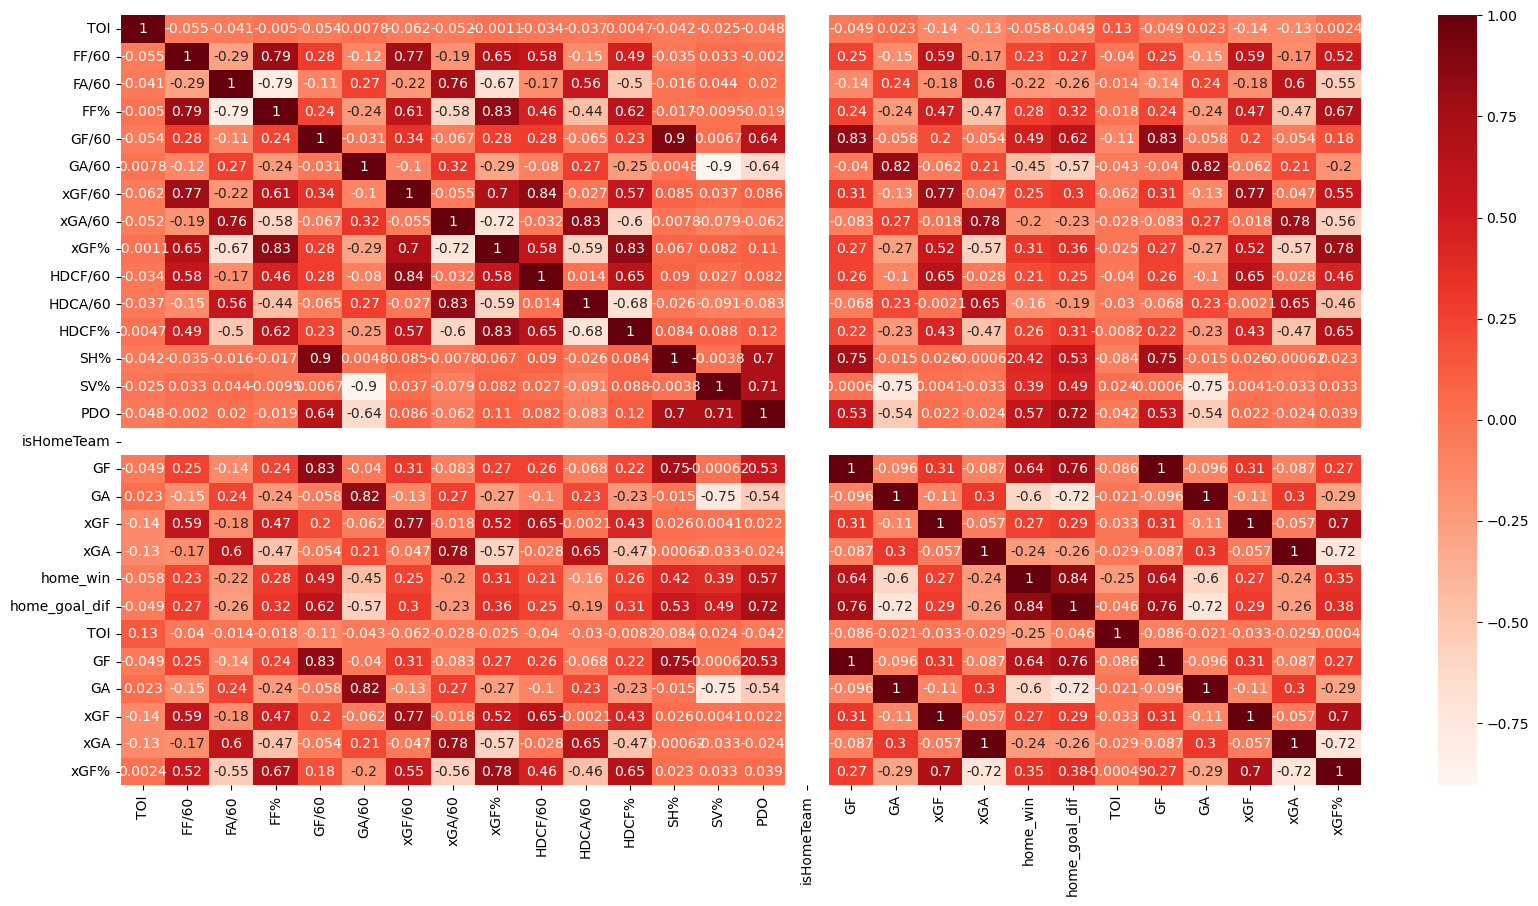

In [77]:
# Check correlation of selected features
plt.figure(figsize=(20,10))
cor = home_model_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Table of heatmap values
home_model_df.corr().sort_values('home_win')

,TOI,FF/60,FA/60,FF%,GF/60,GA/60,xGF/60,xGA/60,xGF%,HDCF/60,...,SH%,SV%,PDO,isHomeTeam,GF,GA,xGF,xGA,home_win,home_goal_dif
GA,0.023368,-0.153073,0.242537,-0.241509,-0.058379,0.824032,-0.127556,0.265501,-0.271293,-0.104907,...,-0.014631,-0.745680,-0.539602,NaN,-0.096287,1.000000,-0.111334,0.303967,-0.600482,-0.722406
GA/60,0.007840,-0.122315,0.269732,-0.240865,-0.031082,1.000000,-0.102017,0.323574,-0.293418,-0.080265,...,0.004810,-0.904281,-0.638375,NaN,-0.039681,0.824032,-0.062179,0.214349,-0.448840,-0.567733
xGA,-0.132683,-0.165862,0.598637,-0.472664,-0.054260,0.214349,-0.046573,0.781766,-0.569797,-0.028110,...,-0.000623,-0.032579,-0.023666,NaN,-0.086989,0.303967,-0.056800,1.000000,-0.241163,-0.259686
FA/60,-0.041437,-0.286500,1.000000,-0.794296,-0.106659,0.269732,-0.217017,0.755230,-0.671988,-0.165019,...,-0.016086,0.043672,0.019610,NaN,-0.139679,0.242537,-0.178055,0.598637,-0.223179,-0.256021
xGA/60,-0.052113,-0.191641,0.755230,-0.583697,-0.066878,0.323574,-0.055239,1.000000,-0.719138,-0.032229,...,-0.007808,-0.079045,-0.061702,NaN,-0.083243,0.265501,-0.018258,0.781766,-0.198092,-0.231869
HDCA/60,-0.037430,-0.152971,0.563438,-0.443593,-0.065001,0.274380,-0.026902,0.831560,-0.588725,0.014210,...,-0.026361,-0.091234,-0.083431,NaN,-0.067985,0.225377,-0.002141,0.646634,-0.159417,-0.194967
TOI,1.000000,-0.055173,-0.041437,-0.005018,-0.053581,0.007840,-0.061678,-0.052113,-0.001079,-0.033917,...,-0.042498,-0.024981,-0.047804,NaN,-0.048756,0.023368,-0.144140,-0.132683,-0.058346,-0.049188
HDCF/60,-0.033917,0.578480,-0.165019,0.457646,0.281645,-0.080265,0.835989,-0.032229,0.579216,1.000000,...,0.089976,0.026528,0.082468,NaN,0.255955,-0.104907,0.650314,-0.028110,0.212289,0.246580
FF/60,-0.055173,1.000000,-0.286500,0.794664,0.279004,-0.122315,0.770039,-0.191641,0.652191,0.578480,...,-0.035409,0.032620,-0.001971,NaN,0.248992,-0.153073,0.590655,-0.165862,0.232087,0.273316
xGF/60,-0.061678,0.770039,-0.217017,0.607087,0.338300,-0.102017,1.000000,-0.055239,0.697641,0.835989,...,0.084883,0.036802,0.086092,NaN,0.305638,-0.127556,0.773285,-0.046573,0.254819,0.295941


### super baseline

In [78]:
# Separate target variable 'goal' from feature set
# and perform a stratified test_train_split due to high imbalance 
X = home_model_df.drop(['home_win'], axis = 1)
y = home_model_df['home_win']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42) # should i stratify?

In [79]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2446, 28) (816, 28) (2446,) (816,)


In [80]:
# Assign training sets of numeric and categorical columns to respective variables
num_features = X_train.select_dtypes(['int', 'float', 'datetime64']).columns
cat_features = X_train.select_dtypes(['object']).columns

In [82]:
# Establish pipelines for each feature type
numeric_pipeline = Pipeline([('ss', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

# declare scoring metric list
scoring = ['neg_log_loss', 'accuracy']

In [83]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
    [("numpipe", numeric_pipeline, num_features),
     ("nominalpipe", nominal_pipeline, cat_features)])

In [84]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state = 42, max_iter=10000))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline.fit(X_train, y_train)

# Predict using the pipeline 
base_log_y_pred = base_log_reg_pipeline.predict(X_test)

ValueError: Selected columns, ['TOI', 'FF/60', 'FA/60', 'FF%', 'GF/60', 'GA/60', 'xGF/60', 'xGA/60', 'xGF%', 'HDCF/60', 'HDCA/60', 'HDCF%', 'SH%', 'SV%', 'PDO', 'isHomeTeam', 'GF', 'GA', 'xGF', 'xGA', 'home_goal_dif', 'TOI', 'GF', 'GA', 'xGF', 'xGA', 'xGF%'], are not unique in dataframe

In [ ]:
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, base_log_y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, base_log_y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 1.000
Test F1 score: 1.000
Test AUC-ROC score: 1.000
Test log loss score: 0.013


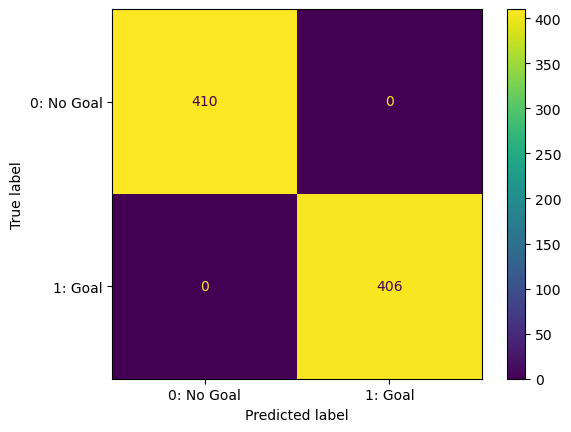

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       1.00      1.00      1.00       406

    accuracy                           1.00       816
   macro avg       1.00      1.00      1.00       816
weighted avg       1.00      1.00      1.00       816

Test log loss score: 0.013
Test AUC-ROC score: 1.000


In [ ]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, base_log_y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, base_log_y_pred)
print(f'Classification report:\n{report}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

In [ ]:
# Regression CV
scores = []
models = []

In [ ]:
# Parameters
c = [0.1, 1, 10, 100]
max_iter = [100, 1000]
solver = ['liblinear']
penalty = ['l1', 'l2']

logreg_params = {
    'logreg__C': c,
    'logreg__max_iter': max_iter,
    'logreg__solver': solver,
    'logreg__penalty': penalty
}

# Model
logreg_top_model_pipe = Pipeline(steps=[("logreg", LogisticRegression(n_jobs=1))], verbose=False)
logreg_top_model = GridSearchCV(estimator=logreg_top_model_pipe, param_grid=logreg_params, scoring='accuracy', cv=5, verbose=0)
logreg_top_model.fit(X_train, y_train)

# Displaying Data
y_pred = logreg_top_model.predict(X_test)
logreg_top_score = logreg_top_model.score(X_test, y_test)

# Model Selection
for i in range(0, 11):
    print(f"Model {i}. Current Top Score: {logreg_top_score}")
        
    # Split X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    
    # Model Building
    logreg_cur_pipe = Pipeline(steps=[("logreg", LogisticRegression(n_jobs=1))], verbose=False)
    logreg_cur_gs = GridSearchCV(estimator=logreg_cur_pipe, param_grid=logreg_params, scoring='accuracy', cv=5, verbose=0)
    logreg_cur_gs.fit(X_train, y_train)
    
    # Comparing and Replacing Data
    y_pred = logreg_cur_gs.predict(X_test)
    logreg_cur_score = logreg_cur_gs.score(X_test, y_test)
    
    if logreg_cur_score > logreg_top_score:
        logreg_top_model = logreg_cur_gs
        logreg_top_score = logreg_cur_score

Model 0. Current Top Score: 1.0
Model 1. Current Top Score: 1.0
Model 2. Current Top Score: 1.0
Model 3. Current Top Score: 1.0
Model 4. Current Top Score: 1.0
Model 5. Current Top Score: 1.0
Model 6. Current Top Score: 1.0
Model 7. Current Top Score: 1.0
Model 8. Current Top Score: 1.0
Model 9. Current Top Score: 1.0
Model 10. Current Top Score: 1.0



Logistic Regression Top Score: 1.0

Best Parameters:
logreg__C: 0.1
logreg__max_iter: 100
logreg__penalty: l1
logreg__solver: liblinear

Cross Validation
Summary Statistics:
          0
count  10.0
mean    1.0
std     0.0
min     1.0
25%     1.0
50%     1.0
75%     1.0
max     1.0



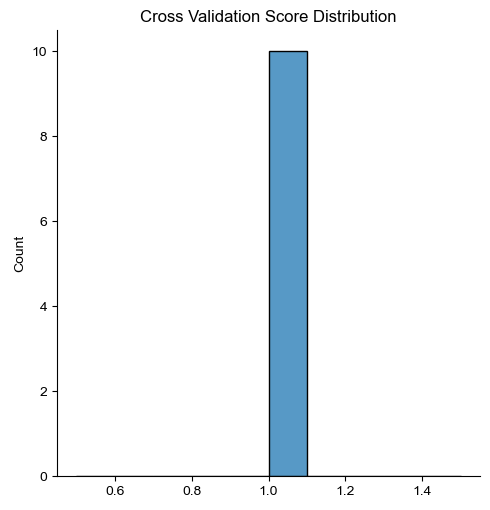

In [ ]:
# Append top score and top model
scores.append(logreg_top_score)
models.append(logreg_top_model)
        
# Displaying Data
print(f"\nLogistic Regression Top Score: {logreg_top_score}\n")
print("Best Parameters:")
for key, value in list(logreg_top_model.best_params_.items()): print(f"{key}: {value}")

logreg_cv = cross_val_score(logreg_top_model, X, y, cv=10, n_jobs=-1)
logreg_cv_df = pd.DataFrame(logreg_cv)
print("\nCross Validation\nSummary Statistics:")
print(f"{logreg_cv_df.describe().to_string()}\n")

sns.displot(logreg_cv, bins=10)
sns.set_style("ticks")
plt.title("Cross Validation Score Distribution")
plt.show()

In [ ]:
# monitor training performance
from numpy import loadtxt

from sklearn.metrics import accuracy_score
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model no training data
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:

import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

N Estimators

N Estimators: 125 - Train Score: 0.0 - Test Score: 0.0
N Estimators: 150 - Train Score: 0.0 - Test Score: 0.0
N Estimators: 175 - Train Score: 0.0 - Test Score: 0.0
N Estimators: 200 - Train Score: 0.0 - Test Score: 0.0
N Estimators: 225 - Train Score: 0.0 - Test Score: 0.0




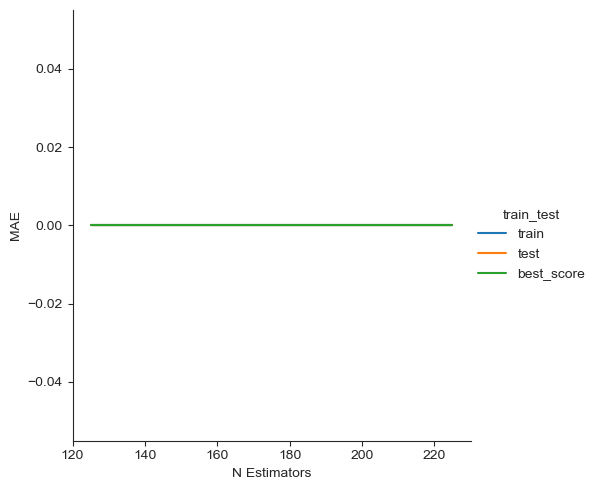

In [ ]:
# Defining the baseline model  without tuning any parameter
model = xgb.XGBClassifier(random_state=42)
results = cross_validate(model, X_train, y_train, cv=5,
                         return_train_score=True, scoring="neg_mean_absolute_error")
                         
# Getting the mean score of the 5 folds (either from train and test)
baseline_mean_train_score = np.multiply(results["train_score"], -1).mean()
baseline_mean_test_score = np.multiply(results["test_score"], -1).mean()

#Step 2: Use GridSearchCV for improving the baseline

# Defining the parameters grid
parameters_grid = {'max_depth': [4, 5, 6], 
                   'learning_rate': [0.1, 0.2, 0.3],
                   'n_estimators': [50, 100, 150], 
                   'gamma': [0, 20], 
                   'subsample': [0.8, 1], 
                   'colsample_bytree': [0.8, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

# Define the model to use with GridSearch
xgboost = xgb.XGBClassifier()

# Use GridSearchCV along XGBoost to find the best parameter combination
xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

# Get and process the results
cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

# Now the baseline has changed
best_score = abs(cv_results.sort_values(by="test_mean_mae", ascending=False).iloc[0]["test_mean_mae"])

#Step 3: Tune parameters individually


def get_cross_validate_scores(df_scores, feature, value, model, X_train, y_train, best_score, metric="neg_mean_absolute_error"):
    # Train the model with cross_validation and get the results
    results = cross_validate(model, X_train, y_train, cv=5,
                             return_train_score=True, scoring=metric)
    # Calculate the metrics
    mean_train_score = np.multiply(results["train_score"], -1).mean()
    mean_test_score = np.multiply(results["test_score"], -1).mean()
    
    # Create different rows to add to the scores.
    print(f"{feature}: {value} - Train Score: {mean_train_score} - Test Score: {mean_test_score}")
    
    train_row_df = pd.DataFrame.from_dict({"value": value,
                                           "train_test": "train",
                                           "score": (results["train_score"] * -1)})
    test_row_df = pd.DataFrame.from_dict({"value": value,
                                          "train_test": "test",
                                          "score": (results["test_score"] * -1)})
    baseline_row_df = pd.DataFrame.from_dict({"value": value,
                                              "train_test": "best_score",
                                              "score": [best_score]})
    # Add the scores obtained to the main dataframe
    df_scores = pd.concat([df_scores, train_row_df, test_row_df, baseline_row_df])
    
    return df_scores

def plot_parameter_scores(feature, df_scores):
    # Create the plot
    parameter_plot = sns.relplot(data=df_scores, x="value", y="score", kind="line", hue="train_test")
    
    # Set the titles and axis labels
    parameter_plot.set_titles(f"{feature} Parameter")
    parameter_plot.set_ylabels("MAE", clear_inner=False)
    parameter_plot.set_xlabels(f"{feature}", clear_inner=False)
    
# Defining the best parameters found with GridSearchCV
gscv_best_params = {"colsample_bytree": 0.8, "eval_metric": "mae",
                    "gamma": 0, "lambda": 1, "learning_rate": 0.1, 
                    "max_depth": 4, "n_estimators": 150, "subsample": 1.0, 
                    "random_state":42}

# Defining, for each parameter, a name without special characters and an array with the values to test
main_parameters_dict = {"n_estimators": ["N Estimators", [125, 150, 175, 200, 225]]}

# Iterating over the parameter dictionary
for parameter, arguments in main_parameters_dict.items():
    # Create an empty dataframe for the scores
    df_scores = pd.DataFrame(columns=["value", "train_test", "score"])
    
    print(f"{arguments[0]}\n")
    
    # Depending on the parameter, different models are built
    for parameter_value in arguments[1]:
        # Getting the best parameters found with GridSearchCV
        params_to_use = gscv_best_params.copy()
        # Adding the individual value of the parameter that we want to test
        params_to_use[parameter] = parameter_value
        
        # Create the XGBoost model with the parameters
        model = xgb.XGBClassifier().set_params(**params_to_use)
        
        # Adding the cross validate scores of a parameter value to the df_scores dataframe
        df_scores = get_cross_validate_scores(df_scores=df_scores, feature=arguments[0], value=parameter_value, model=model,
                                              X_train=X_train, y_train=y_train, best_score=best_score)
    
    # Plot the parameter scores
    plot_parameter_scores(arguments[0], df_scores)
    
    print("\n")

In [ ]:
# Step 4: Repeat steps 2 and 3.

# Using the information gathered before to define the parameters grid
parameters_grid = {'max_depth': [4, 5], 
                   'learning_rate': [0.05, 0.1, 0.15],
                   'n_estimators': [150, 300, 450], 
                   'gamma': [0, 20], 
                   'subsample': [0.7, 1], 
                   'colsample_bytree': [0.7, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

xgboost = xgb.XGBRegressor()

xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

# Step 5: Use the test set to validate the model.

#Finally, we need to validate the model built with the test set 
# (holdout test, no validation test) of step 0.

# Calculate the Mean Absolute Error for the Test Set
test_mae = mean_absolute_error(y_true=y_test, y_pred=xgb_gscv.best_estimator_.predict(X_test))

In [ ]:
# build baseline trees pipeplin
steps = [('preprocess', ct), 
         ('rf', RandomForestClassifier(random_state = 42))]

rf_pipeline = Pipeline(steps)

rf_pipeline.fit(X_train, y_train)

In [ ]:
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, base_log_y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, base_log_y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

In [ ]:
# Logistic Regression w/ Grid Search

# Parameters
c = [0.1, 1, 10, 100]
max_iter = [100, 1000]
solver = ['liblinear']
penalty = ['l1', 'l2']

logreg_params = {
    'logreg__C': c,
    'logreg__max_iter': max_iter,
    'logreg__solver': solver,
    'logreg__penalty': penalty
}

# Model
logreg_top_model_pipe = Pipeline(steps=[("logreg", LogisticRegression(n_jobs=1))], verbose=False)
logreg_top_model = GridSearchCV(estimator=logreg_top_model_pipe, param_grid=logreg_params, scoring='accuracy', cv=5, verbose=0)
logreg_top_model.fit(X_train, y_train)

# Displaying Data
y_pred = logreg_top_model.predict(X_test)
logreg_top_score = logreg_top_model.score(X_test, y_test)

# Model Selection
for i in range(0, 11):
    print(f"Model {i}. Current Top Score: {logreg_top_score}")
        
    # Split X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    
    # Model Building
    logreg_cur_pipe = Pipeline(steps=[("logreg", LogisticRegression(n_jobs=1))], verbose=False)
    logreg_cur_gs = GridSearchCV(estimator=logreg_cur_pipe, param_grid=logreg_params, scoring='accuracy', cv=5, verbose=0)
    logreg_cur_gs.fit(X_train, y_train)
    
    # Comparing and Replacing Data
    y_pred = logreg_cur_gs.predict(X_test)
    logreg_cur_score = logreg_cur_gs.score(X_test, y_test)
    
    if logreg_cur_score > logreg_top_score:
        logreg_top_model = logreg_cur_gs
        logreg_top_score = logreg_cur_score

Model 0. Current Top Score: 1.0
Model 1. Current Top Score: 1.0
Model 2. Current Top Score: 1.0
Model 3. Current Top Score: 1.0
Model 4. Current Top Score: 1.0
Model 5. Current Top Score: 1.0
Model 6. Current Top Score: 1.0
Model 7. Current Top Score: 1.0
Model 8. Current Top Score: 1.0
Model 9. Current Top Score: 1.0
Model 10. Current Top Score: 1.0


In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={"min_samples_split": range(2, 403, 20)},
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

In [ ]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)


In [ ]:
len(X)

8000

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

rng = np.random.RandomState(0)
X, y = make_classification(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf.fit(X_train, y_train).score(X_test, y_test)


0.96